In [1]:
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(kableExtra))
suppressPackageStartupMessages(library(recipes))
suppressPackageStartupMessages(library(survival))
suppressPackageStartupMessages(library(tidyverse))

In [2]:
con <- DBI::dbConnect(
    RMariaDB::MariaDB(),
    host = "localhost",
    user = "mnz2108",
    dbname = "user_mnz2108",
    password = read_file('~/git/abo_covid_analysis/mysql_password.txt') %>% str_squish
)

## 1. Gather data

In [3]:
# Demographics and outcomes
demogs_outcomes_df <- con %>% tbl('tmprss2_complete') %>% as_tibble

# Drug exposures
drug_exposures_df <- con %>% tbl('tmprss2_drug_exposures') %>% as_tibble

# Propensity matching conditions
conditions_df <- con %>% tbl('tmprss2_match_condition_occurrences') %>% as_tibble

In [4]:
full_df <- demogs_outcomes_df %>%
    # Add drug exposures (with explicit non-exposure)
    left_join(
        drug_exposures_df %>% distinct(pat_mrn_id, drug_class_name) %>% mutate(had_drug = 1),
        by = 'pat_mrn_id'
    ) %>%
    complete(nesting(pat_mrn_id, male_sex, age, race, ethnicity, intubated, cov_start_to_intubation,
                     died, cov_start_to_death), nesting(drug_class_name)) %>%
    filter(!is.na(drug_class_name)) %>%
    replace_na(list(had_drug = 0)) %>%
    # Don't look at drug classes with < 100 people
    group_by(drug_class_name) %>%
    filter(sum(had_drug) >= 100) %>%
    ungroup %>%
    # Add conditions for matching
    left_join(
        conditions_df %>% 
            mutate(had_icd = 1) %>%
            pivot_wider(names_from = icd10, values_from = had_icd, 
                        values_fill = list(had_icd = 0), names_prefix = 'icd_'),
        by = 'pat_mrn_id'
    ) %>%
    mutate(across(starts_with('icd_'), ~replace_na(., 0))) %>%
    # One-hot encode race and ethnicity
    recipe() %>%
    step_dummy(race, ethnicity, one_hot = T) %>%
    prep() %>%
    juice()

In [5]:
# QC no NaNs in the table
full_df %>% map(~sum(is.na(.x))) %>% keep(~. > 0)

named list()

## 2. Propensity matching

In [6]:
stratified_propensity_match <- function(formula, data, n_bins = 50, control_to_case_ratio = 1) {
    # Stratified propensity score matching. Computes a propensity score using 
    # logistic regression on the given formula. Scores are discretized into `n_bins` bins, 
    # and controls are sampled at a ratio of `control_to_case_ratio`, with replacement if the 
    # number of needed controls is larger than the number available.
    bin_edges = seq(0, 1, length.out = n_bins + 2)
    outcome = formula %>% all.vars() %>% first
    set.seed(0)    
    data %>%
        glm(formula, data = ., family = binomial()) %>%
        augment(data = data, type.predict = "response") %>%
        select(everything(), -starts_with('.'), 'propensity_score' = '.fitted') %>%
        mutate(
            outcome = !!as.name(outcome),
            propensity_bin = findInterval(propensity_score, bin_edges)
        ) %>%
        group_by(propensity_bin) %>%
        mutate(
            n_exposed = sum(outcome),
            n_unexposed = n() - n_exposed,
        ) %>%
        filter(n_exposed > 0, n_unexposed > 0) %>%
        ungroup %>%
        nest(data = c(-propensity_bin, -outcome, -n_exposed, -n_unexposed)) %>%
        mutate(
            n_to_sample = if_else(outcome == 1, n_exposed, control_to_case_ratio * n_exposed),
            replace = as.logical(outcome == 0 & n_to_sample > n_unexposed),
            data = pmap(list(data, n_to_sample, replace), ~sample_n(tbl = ..1, size = ..2, replace = ..3)),
        ) %>%
        select(data) %>%
        unnest(data)
}

In [7]:
# Use race=white and ethnicity=non-hispanic as reference groups
match_formula <- full_df %>% 
    select(age, male_sex, starts_with('race_'), -race_white, 
           starts_with('ethnicity_'), -ethnicity_nonhs, starts_with('icd_')) %>% 
    names %>%
    paste(collapse = ' + ') %>%
    str_c('had_drug ~ ', .)

In [8]:
options(warn = -1)

propensity_matched_df <- full_df %>%
    nest(unmatched = c(-drug_class_name)) %>%
    mutate(
        matched = unmatched %>% 
            map(~stratified_propensity_match(formula(match_formula), .x, n_bins = 20, control_to_case_ratio = 3))
    ) %>%
    pivot_longer(c(unmatched, matched), names_to = 'match_type', values_to = 'data') %>%
    unnest(data) %>%
    select(-starts_with('icd_')) %>%
    replace_na(list(propensity_score = 0))

options(warn = 0)

## 3. Effect size estimatation

In [9]:
format_counts <- function(df) {
    df %>% 
    summarize(
        n_exposed = sum(had_drug * had_outcome), 
        frac_exposed = (100 * n_exposed / sum(had_drug)) %>% round(1),
        n_unexposed = sum((1 - had_drug) * had_outcome),
        frac_unexposed = (100 * n_unexposed / sum(1 - had_drug)) %>% round(1),
        exposed = str_glue('{n_exposed} ({frac_exposed}%)'),
        unexposed = str_glue('{n_unexposed} ({frac_unexposed}%)')
    ) %>%
    select(exposed, unexposed)
}

In [10]:
adjusted_formula <- propensity_matched_df %>%
    select(had_drug, male_sex, age, starts_with('race_'), -race_white, 
           starts_with('ethnicity_'), -ethnicity_nonhs, propensity_score) %>%
    names %>%
    paste(collapse = ' + ') %>%
    str_c('Surv(time_to_outcome, had_outcome) ~ ', .)

In [11]:
regression_coefficients_df <- propensity_matched_df %>%
    mutate(
        # These outcomes have the same start time, so the earliest is the max, unless they are 
        # equal, in which case it doesn't matter.
        intubated_or_died = pmax(intubated, died),
        cov_start_to_intubation_or_death = pmin(cov_start_to_intubation, cov_start_to_death)
    ) %>%
    unite('intubation', c(intubated, cov_start_to_intubation)) %>%
    unite('death', c(died, cov_start_to_death)) %>%
    unite('intubation_or_death', c(intubated_or_died, cov_start_to_intubation_or_death)) %>%
    pivot_longer(c(intubation, death, intubation_or_death), names_to = 'outcome', 
                 values_to = 'outcome_combined') %>%
    separate(outcome_combined, c('had_outcome', 'time_to_outcome'), sep = '_', convert = T) %>%
    nest(data = c(-outcome, -match_type, -drug_class_name)) %>%
    mutate(
        counts = data %>% map(format_counts),
        reg = data %>% map(~coxph(formula(adjusted_formula), data = .x)) %>% map(tidy),
    ) %>%
    select(-data) %>%
    unnest(cols = c(reg, counts))

Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4 ; coefficient may be infinite. ”
Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4 ; coefficient may be infinite. ”
Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  4 ; coefficient may be infinite. ”


## 4. Plots

In [12]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

forest_plot_df <- regression_coefficients_df %>%
    filter(term == 'had_drug') %>%
    mutate(
        drug_class_name = drug_class_name %>% fct_rev,
        outcome = outcome %>% str_replace_all('_', ' ') %>% fct_rev,
        match_type = match_type,
        p.value = p.value %>% sprintf(fmt = '%.2g'),
        conf.low = estimate - 1.96 * std.error,
        conf.high = estimate + 1.96 * std.error,
        across(c(estimate, conf.low, conf.high), exp)
    ) %>%
    select(-term, -std.error, -statistic)

forest_ggplot <- forest_plot_df %>%
    ggplot(aes(x = estimate, xmin = conf.low, xmax = conf.high, y = drug_class_name, 
               group = match_type, color = match_type, shape = match_type)) +
    geom_vline(xintercept = 1, color = 'grey50', linetype = 'dashed') +
    geom_errorbarh(position = position_dodge(width = 0.5), height = 0.2) +
    geom_point(position = position_dodge(width = 0.5)) +
    facet_wrap(vars(outcome)) +
    xlab('Hazard ratio (95% CI)') +
    theme_cowplot() +
    theme(
        panel.background = element_rect(color = 'black'),
        axis.title.y = element_blank(),
        legend.title = element_blank(),
    ) +
    guides(color = guide_legend(reverse = T), shape = guide_legend(reverse = T))

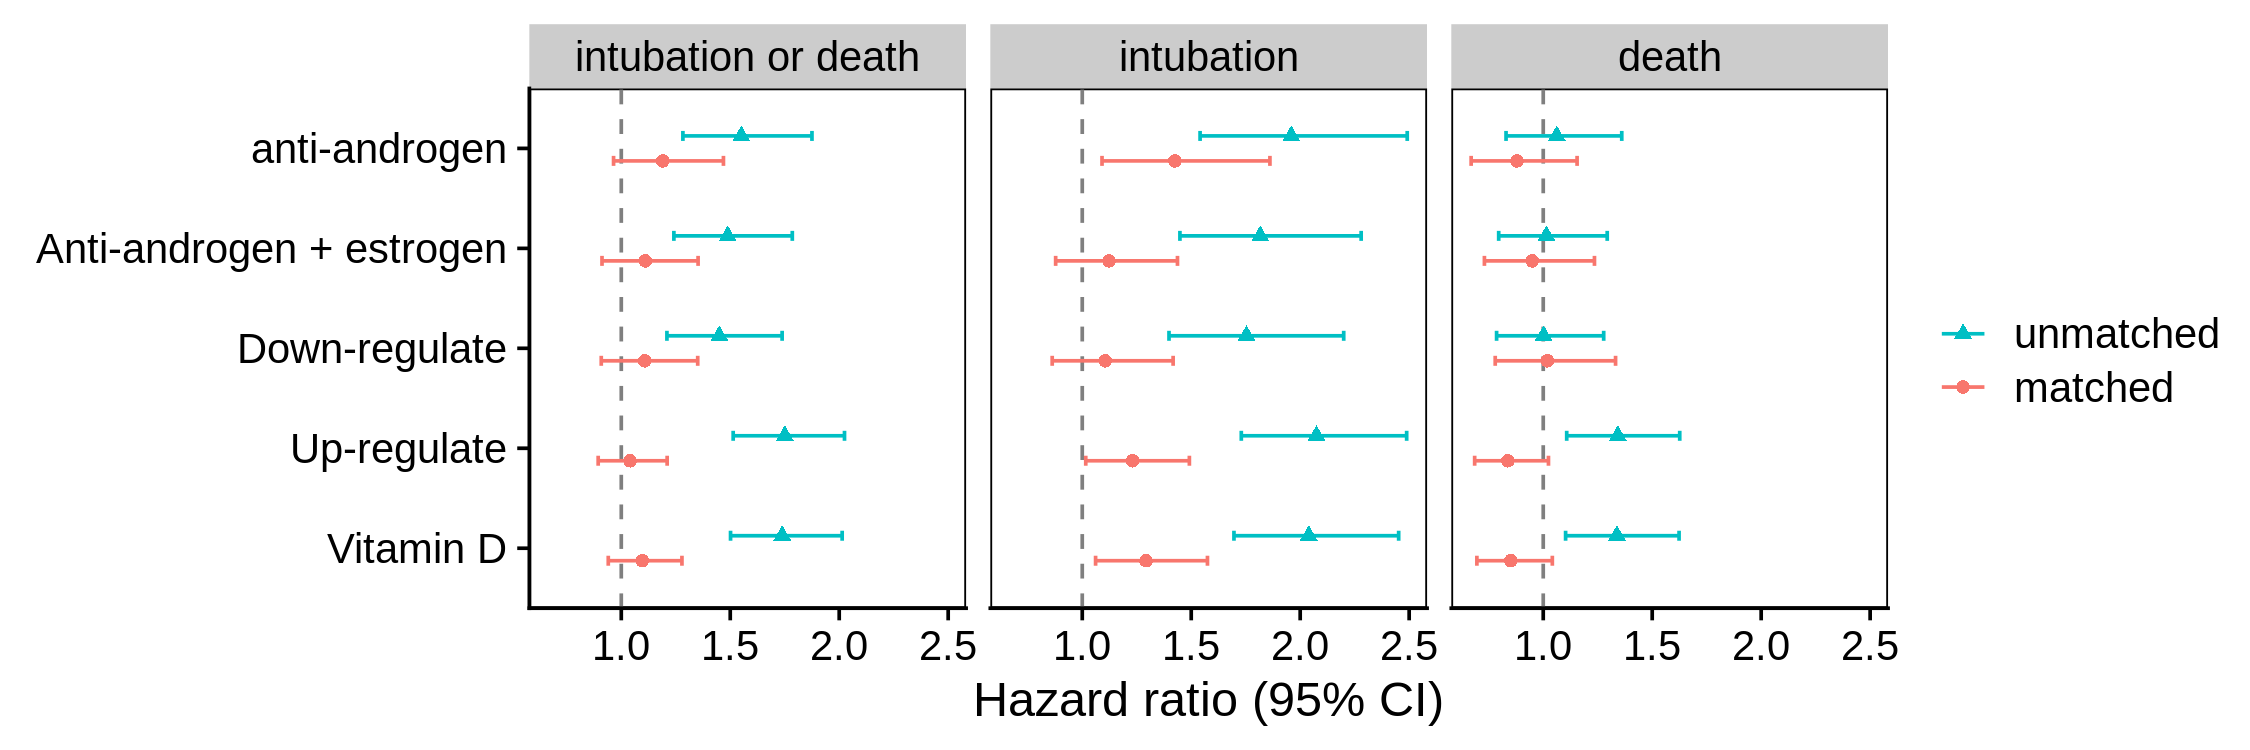

In [13]:
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 250)

ggsave('img/effect_size_plot.pdf', forest_ggplot, width = 9, height = 3)
ggsave('img/effect_size_plot.png', forest_ggplot, width = 9, height = 3, dpi = 400)

forest_ggplot

In [14]:
forest_table <- forest_plot_df %>%
    mutate(
        estimate = estimate %>% round(2),
        '95% CI' = str_c(round(conf.low, 2), '-', round(conf.high, 2))
    ) %>%
    rename('Drug class' = 'drug_class_name', 'Treated' = 'exposed', 'Control' = 'unexposed',
           'HR' = 'estimate', 'p-value' = 'p.value') %>%
    select(-conf.low, -conf.high) %>%
    nest(data = c(`Treated`, `Control`, `HR`, `95% CI`, `p-value`)) %>%
    pivot_wider(names_from = match_type, values_from = data) %>%
    arrange(outcome) %>%
    relocate(outcome) %>%
    rename("Outcome" = outcome) %>%
    unnest(c(unmatched, matched), names_repair = 'minimal') %>%
    kable() %>%
    kable_styling(bootstrap_options = c("striped", "responsive", "hover"), full_width = F) %>%
    add_header_above(c(" " = 2, "Unmatched" = 5, "Matched" = 5)) %>%
    collapse_rows(columns = 1:2)

forest_table %>% save_kable(file = 'img/effect_estimate_table.html')
forest_table %>% save_kable(file = 'img/effect_estimate_table.png', zoom = 5)

forest_table %>%
    as.character %>%
    IRdisplay::display_html()

save_kable will have the best result with magick installed. 



Unmatched 
 Matched 
 
 
 Outcome 
 Drug class 
 Treated 
 Control 
 HR 
 95% CI 
 p-value 
 Treated 
 Control 
 HR 
 95% CI 
 p-value 
 
 
 
 
 intubation or death 
 anti-androgen 
 125 (36.5%) 
 1056 (18.1%) 
 1.55 
 1.28-1.87 
 5.9e-06 
 120 (36.9%) 
 324 (33.2%) 
 1.19 
 0.96-1.47 
 0.1 
 
 
 
 Anti-androgen + estrogen 
 135 (31.8%) 
 1046 (18.2%) 
 1.49 
 1.24-1.78 
 1.8e-05 
 135 (31.8%) 
 378 (29.7%) 
 1.11 
 0.91-1.35 
 0.3 
 
 
 
 Down-regulate 
 135 (30.8%) 
 1046 (18.2%) 
 1.45 
 1.21-1.74 
 5.9e-05 
 133 (30.9%) 
 373 (28.8%) 
 1.11 
 0.91-1.35 
 0.31 
 
 
 
 Up-regulate 
 230 (31.7%) 
 951 (17.4%) 
 1.75 
 1.51-2.02 
 4.5e-14 
 230 (31.7%) 
 670 (30.8%) 
 1.04 
 0.89-1.21 
 0.61 
 
 
 
 Vitamin D 
 225 (31.8%) 
 956 (17.5%) 
 1.74 
 1.5-2.01 
 1.5e-13 
 225 (31.8%) 
 641 (30.2%) 
 1.10 
 0.94-1.28 
 0.24 
 
 
 intubation 
 anti-androgen 
 79 (23.1%) 
 626 (10.7%) 
 1.96 
 1.54-2.49 
 4.1e-08 
 78 (24%) 
 177 (18.2%) 
 1.42 
 1.09-1.86 
 0.0094 
 
 
 
 Anti-androgen + estrogen 
 87 (20.5%) 
 618 (10.7%) 
 1.82 
 1.45-2.28 
 2.5e-07 
 87 (20.5%) 
 241 (18.9%) 
 1.12 
 0.88-1.44 
 0.36 
 
 
 
 Down-regulate 
 87 (19.9%) 
 618 (10.8%) 
 1.75 
 1.4-2.2 
 1.2e-06 
 85 (19.7%) 
 239 (18.5%) 
 1.11 
 0.86-1.42 
 0.43 
 
 
 
 Up-regulate 
 150 (20.7%) 
 555 (10.2%) 
 2.07 
 1.73-2.49 
 3.7e-15 
 150 (20.7%) 
 366 (16.8%) 
 1.23 
 1.02-1.49 
 0.034 
 
 
 
 Vitamin D 
 145 (20.5%) 
 560 (10.2%) 
 2.04 
 1.7-2.45 
 3.5e-14 
 145 (20.5%) 
 335 (15.8%) 
 1.29 
 1.06-1.57 
 0.011 
 
 
 death 
 anti-androgen 
 72 (21.1%) 
 699 (12%) 
 1.06 
 0.83-1.36 
 0.63 
 67 (20.6%) 
 238 (24.4%) 
 0.88 
 0.67-1.16 
 0.36 
 
 
 
 Anti-androgen + estrogen 
 74 (17.5%) 
 697 (12.1%) 
 1.01 
 0.8-1.29 
 0.91 
 74 (17.5%) 
 238 (18.7%) 
 0.95 
 0.73-1.24 
 0.7 
 
 
 
 Down-regulate 
 74 (16.9%) 
 697 (12.1%) 
 1.00 
 0.79-1.28 
 0.99 
 72 (16.7%) 
 220 (17%) 
 1.02 
 0.78-1.33 
 0.89 
 
 
 
 Up-regulate 
 127 (17.5%) 
 644 (11.8%) 
 1.34 
 1.11-1.63 
 0.0027 
 127 (17.5%) 
 442 (20.3%) 
 0.84 
 0.69-1.02 
 0.084 
 
 
 
 Vitamin D 
 125 (17.7%) 
 646 (11.8%) 
 1.34 
 1.1-1.62 
 0.0032 
 125 (17.7%) 
 439 (20.7%) 
 0.85 
 0.7-1.04 
 0.12

## 5. Export to Google Drive

In [15]:
library(googlesheets4)
gs4_auth(email = 'michael.zietz@gmail.com', path = '~/.ssh/xswap-compute-5b866b2d1e2f.json', 
         use_oob = TRUE)

library(googledrive)
drive_auth(email = 'michael.zietz@gmail.com', path = '~/.ssh/xswap-compute-5b866b2d1e2f.json')


Attaching package: ‘googledrive’


The following objects are masked from ‘package:googlesheets4’:

    request_generate, request_make




In [16]:
ss <- gs4_get(drive_get(path = 'Research/TMPRSS2_v2.0'))

In [17]:
con %>% tbl('tmprss2_drugs') %>% as_tibble %>%
    mutate(across(everything(), as.character)) %>%
    write_sheet(ss, 'definitions')

con %>% tbl('tmprss2_class_aggregate') %>% as_tibble %>%
    mutate(across(everything(), as.character)) %>%
    write_sheet(ss, 'class_counts')

con %>% tbl('tmprss2_drug_aggregate') %>% as_tibble %>%
    mutate(across(everything(), as.character)) %>%
    write_sheet(ss, 'drug_counts')

forest_plot_df %>%
    mutate(
        estimate = estimate %>% round(2),
        '95% CI' = str_c(round(conf.low, 2), '-', round(conf.high, 2))
    ) %>%
    rename('Drug class' = 'drug_class_name', 'Treated' = 'exposed', 'Control' = 'unexposed',
           'HR' = 'estimate', 'p-value' = 'p.value') %>%
    select(-conf.low, -conf.high) %>%
    arrange(outcome) %>%
    relocate(outcome) %>%
    relocate(`p-value`, .after = `95% CI`) %>%
    rename("Outcome" = outcome) %>%
    write_sheet(ss, 'effect_sizes')

Writing to "TMPRSS2_v2.0"

Writing to sheet "definitions"

Writing to "TMPRSS2_v2.0"

Writing to sheet "class_counts"

Writing to "TMPRSS2_v2.0"

Writing to sheet "drug_counts"

Writing to "TMPRSS2_v2.0"

Writing to sheet "effect_sizes"



In [18]:
# Auto-resize columns
outputs <- list('definitions', 'class_counts', 'drug_counts', 'effect_sizes') %>%
    map(~range_autofit(ss, sheet = .x, dimension = "columns"))

Editing "TMPRSS2_v2.0"

Resizing one or more columns in "definitions"

Editing "TMPRSS2_v2.0"

Resizing one or more columns in "class_counts"

Editing "TMPRSS2_v2.0"

Resizing one or more columns in "drug_counts"

Editing "TMPRSS2_v2.0"

Resizing one or more columns in "effect_sizes"

